In [1]:
import gc
import os
from pathlib import Path
import random
import sys

from datetime import datetime
from pytz import timezone
from pandas.tseries.offsets import DateOffset

from tqdm import tqdm_notebook as tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

In [2]:
# Define a function to convert the UTC time to EST
def convert_to_est(utc_time_str):
    utc_time = datetime.fromisoformat(utc_time_str.replace("Z", "+00:00"))
    est_timezone = timezone('US/Eastern')
    est_time = utc_time.astimezone(est_timezone)
    return est_time

In [3]:
# import requests
# from datetime import datetime, timedelta

# # Step 1: Get the nearest weather station to Pittsburgh
# station_id = "USW00094823"

# # Step 2: Calculate the start and end dates for the last 24 hours
# end_date = '2023-04-28T01:00:00-04:00'

# start_date = '2023-04-20T04:00:00-04:00'

# # Step 3: Prepare the API request
# api_key = "BQkPFrkJhzMuaYCYsuKpfmbmgctlZxxn"  # Replace with your actual API key
# url = "https://www.ncei.noaa.gov/access/services/data/v1"
# params = {
#     "dataset": "normals-hourly",
#     "dataTypes": "HLY-TEMP-NORMAL",
#     "stations": station_id,
#     "startDate": start_date,
#     "endDate": end_date,
#     "format": "json",
#     "units": "metric",
#     "token": api_key,
# }

# # Send the API request and get the response
# response = requests.get(url, params=params)
# hourly_normals_data = response.json()

# # Step 3: Parse the response and extract the relevant hourly normals data
# hourly_normals = []

# for entry in hourly_normals_data:
#     timestamp = entry["DATE"]
#     temp_normal = entry["HLY-TEMP-NORMAL"]  # Temperature in Celsius
#     hourly_normals.append({"timestamp": timestamp, "oat": temp_normal})

# # Convert the list of dictionaries into a DataFrame
# df_oat = pd.DataFrame(hourly_normals)

# # Convert the 'timestamp' column to datetime objects and localize to Eastern Time
# df_oat['timestamp'] = pd.to_datetime(df_oat['timestamp'], format='%m-%dT%H:%M:%S') + DateOffset(years=123) - DateOffset(hours=4)

# # Convert the 'temperature_normal' column to float
# df_oat['oat'] = df_oat['oat'].astype(float)

In [4]:
# df_oat['timestamp'] = df_oat['timestamp'].dt.round('5T')
# # Set the index to the 'timestamp' column
# df_oat.set_index('timestamp', inplace=True)

# # Resample the DataFrame to 15-minute intervals and interpolate missing values
# df_oa = df_oat.resample('5T').interpolate()

In [102]:
df_oa = pd.read_csv('noaa.csv')

In [103]:
df_oa

,DATE,REPORT_TYPE,CALL_SIGN,QUALITY_CONTROL,WND,CIG,VIS,TMP,DEW,SLP
0,2023-04-01T00:53:00,FM-15,KAGC,V020,"190,5,N,0046,5","00396,5,M,N","016093,5,N,5","+0117,5","+0100,5","10103,5"
1,2023-04-01T01:37:00,FM-16,KAGC,V020,"190,5,N,0057,5","00457,5,M,N","016093,5,N,5","+0122,5","+0106,5","99999,9"
2,2023-04-01T01:53:00,FM-15,KAGC,V020,"180,5,N,0046,5","00457,5,M,N","016093,5,N,5","+0122,5","+0106,5","10094,5"
3,2023-04-01T02:53:00,FM-15,KAGC,V020,"190,5,N,0051,5","00640,5,M,N","016093,5,N,5","+0122,5","+0106,5","10087,5"
4,2023-04-01T03:53:00,FM-15,KAGC,V020,"180,5,N,0051,5","00549,5,M,N","012875,5,N,5","+0128,5","+0106,5","10071,5"
...,...,...,...,...,...,...,...,...,...,...
1080,2023-05-04T03:53:00,FM-15,KAGC,V020,"300,5,N,0051,5","00518,5,M,N","011265,5,N,5","+0072,5","+0050,5","10089,5"
1081,2023-05-04T04:53:00,FM-15,KAGC,V020,"300,5,V,0036,5","00518,5,M,N","016093,5,N,5","+0072,5","+0056,5","10094,5"
1082,2023-05-04T04:59:00,SOD,KAGC,V020,"999,9,9,9999,9","99999,9,9,9","999999,9,9,9","+9999,9","+9999,9","99999,9"
1083,2023-05-04T05:53:00,FM-15,KAGC,V020,"999,9,V,0031,5","00396,5,M,N","016093,5,N,5","+0072,5","+0056,5","10097,5"


In [104]:
# Apply the conversion function to the time column
df_oa['timestamp'] = df_oa['DATE'].apply(convert_to_est)

In [105]:
# Set the time column as pandas datetime datatype
df_oa['timestamp'] = pd.to_datetime(df_oa['timestamp']).dt.tz_localize(None) - DateOffset(hours=4)

In [106]:
df_oa

,DATE,REPORT_TYPE,CALL_SIGN,QUALITY_CONTROL,WND,CIG,VIS,TMP,DEW,SLP,timestamp
0,2023-04-01T00:53:00,FM-15,KAGC,V020,"190,5,N,0046,5","00396,5,M,N","016093,5,N,5","+0117,5","+0100,5","10103,5",2023-03-31 20:53:00
1,2023-04-01T01:37:00,FM-16,KAGC,V020,"190,5,N,0057,5","00457,5,M,N","016093,5,N,5","+0122,5","+0106,5","99999,9",2023-03-31 21:37:00
2,2023-04-01T01:53:00,FM-15,KAGC,V020,"180,5,N,0046,5","00457,5,M,N","016093,5,N,5","+0122,5","+0106,5","10094,5",2023-03-31 21:53:00
3,2023-04-01T02:53:00,FM-15,KAGC,V020,"190,5,N,0051,5","00640,5,M,N","016093,5,N,5","+0122,5","+0106,5","10087,5",2023-03-31 22:53:00
4,2023-04-01T03:53:00,FM-15,KAGC,V020,"180,5,N,0051,5","00549,5,M,N","012875,5,N,5","+0128,5","+0106,5","10071,5",2023-03-31 23:53:00
...,...,...,...,...,...,...,...,...,...,...,...
1080,2023-05-04T03:53:00,FM-15,KAGC,V020,"300,5,N,0051,5","00518,5,M,N","011265,5,N,5","+0072,5","+0050,5","10089,5",2023-05-03 23:53:00
1081,2023-05-04T04:53:00,FM-15,KAGC,V020,"300,5,V,0036,5","00518,5,M,N","016093,5,N,5","+0072,5","+0056,5","10094,5",2023-05-04 00:53:00
1082,2023-05-04T04:59:00,SOD,KAGC,V020,"999,9,9,9999,9","99999,9,9,9","999999,9,9,9","+9999,9","+9999,9","99999,9",2023-05-04 00:59:00
1083,2023-05-04T05:53:00,FM-15,KAGC,V020,"999,9,V,0031,5","00396,5,M,N","016093,5,N,5","+0072,5","+0056,5","10097,5",2023-05-04 01:53:00


In [107]:
def convert_to_celcius(temp_str):
    # Remove the leading "+" sign and comma
    temp_str = temp_str.replace("+", "").replace(",", "")

    # Convert the string to an integer and divide by 10 to get degrees Celsius
    temp_celsius = int(temp_str) / 100
    
    return temp_celsius

In [108]:
df_oa = df_oa[df_oa['REPORT_TYPE'] != "SOD  "]

In [109]:
df_oa = df_oa[df_oa['REPORT_TYPE'] != "SOM  "]

In [110]:
# Convert the temperature using the convert_to_fahrenheit function
df_oa['oat'] = df_oa['TMP'].apply(convert_to_celcius)

In [184]:
cols = ['timestamp','oat']
df_oat = df_oa[cols]

In [185]:
# Set the index to the 'timestamp' column
df_oat.set_index('timestamp', inplace=True)

# Resample the DataFrame to 15-minute intervals and interpolate missing values
df_oat = df_oat.resample('1T').interpolate()

In [186]:
df_oat = df_oat.resample('5T').mean()

In [187]:
df_oat

,oat
timestamp,
2023-03-31 20:50:00,11.755682
2023-03-31 20:55:00,11.795455
2023-03-31 21:00:00,11.852273
2023-03-31 21:05:00,11.909091
2023-03-31 21:10:00,11.965909
...,...
2023-05-04 02:30:00,6.925000
2023-05-04 02:35:00,6.883333
2023-05-04 02:40:00,6.841667


In [189]:
df = pd.read_csv('final_influxdb_data.csv')

In [190]:
df

,_time,_value,_field,location
0,2023-04-25T01:35:00Z,30.150000,humidity,bed
1,2023-04-25T01:40:00Z,30.715000,humidity,bed
2,2023-04-25T01:45:00Z,31.210000,humidity,bed
3,2023-04-25T01:50:00Z,31.394444,humidity,bed
4,2023-04-25T01:55:00Z,31.375000,humidity,bed
...,...,...,...,...
13969,2023-04-29T03:40:00Z,22.520000,temperature,vent
13970,2023-04-29T03:45:00Z,22.454211,temperature,vent
13971,2023-04-29T03:50:00Z,22.408947,temperature,vent
13972,2023-04-29T03:55:00Z,22.403500,temperature,vent


In [191]:
# Apply the conversion function to the time column
df['timestamp'] = df['_time'].apply(convert_to_est)
# Set the time column as pandas datetime datatype
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_localize(None)

In [192]:
df_temp = df[df['_field'] == 'temperature']

In [193]:
df_temp = df_temp.drop(columns=['_time', '_field'])

In [194]:
df_temp = df_temp.pivot_table(index="timestamp", columns="location", values="_value").reset_index()

In [195]:
df_temp

location,timestamp,bed,kitchen,livingroom,office,thermostat,vent
0,2023-04-24 21:35:00,24.040625,24.076500,24.490000,24.207000,24.015000,25.787368
1,2023-04-24 21:40:00,23.824500,24.005556,24.148889,23.965500,23.792941,24.424000
2,2023-04-24 21:45:00,23.649500,23.932778,24.011875,23.799412,23.617222,23.835294
3,2023-04-24 21:50:00,23.564444,23.794500,23.969474,23.692105,23.484500,23.575000
4,2023-04-24 21:55:00,23.498750,23.738947,23.822778,23.566500,23.427000,23.379474
...,...,...,...,...,...,...,...
1177,2023-04-28 23:40:00,23.000000,23.396500,23.305000,23.044706,22.998500,22.520000
1178,2023-04-28 23:45:00,23.001053,23.380000,23.326471,22.971111,22.966111,22.454211
1179,2023-04-28 23:50:00,22.973500,23.377059,23.257647,22.965500,22.959412,22.408947
1180,2023-04-28 23:55:00,22.930526,23.377222,23.134211,22.955500,22.960000,22.403500


In [196]:
df_temp.corr()

/var/folders/0w/98g43rqs1psflll78k6ctzr00000gn/T/ipykernel_65742/1996446789.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



location,bed,kitchen,livingroom,office,thermostat,vent
location,,,,,,
bed,1.000000,0.829014,0.957245,0.989212,0.987815,0.541740
kitchen,0.829014,1.000000,0.798170,0.843686,0.848671,0.350937
livingroom,0.957245,0.798170,1.000000,0.956957,0.956212,0.677967
office,0.989212,0.843686,0.956957,1.000000,0.995500,0.559523
thermostat,0.987815,0.848671,0.956212,0.995500,1.000000,0.541965
vent,0.541740,0.350937,0.677967,0.559523,0.541965,1.000000


In [197]:
df_temp.set_index('timestamp', inplace=True)

/Users/weiliang/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning:

Degrees of freedom <= 0 for slice

/Users/weiliang/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning:

divide by zero encountered in true_divide



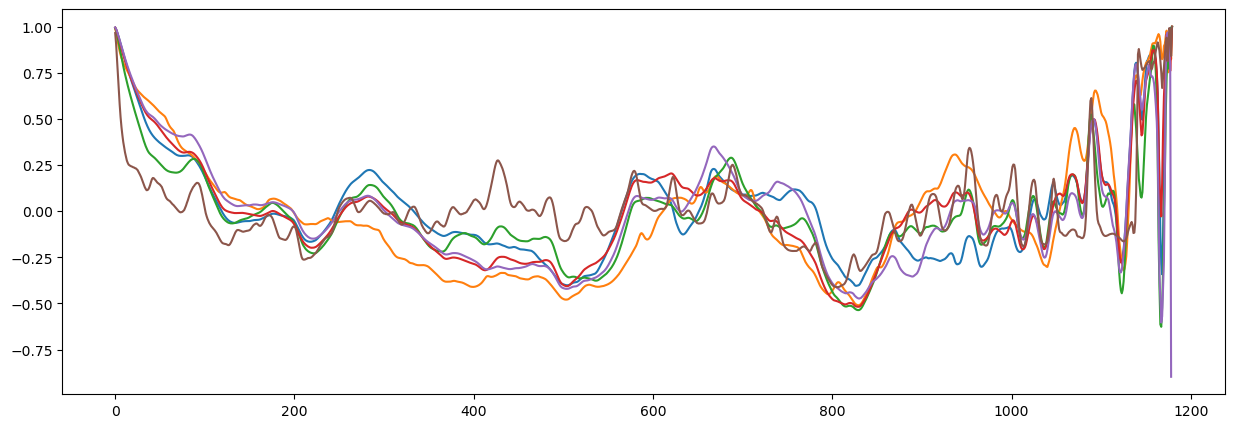

In [206]:
plt.figure(figsize=(15, 5))
for loc in df_temp.columns:
    # Compute autocorrelation
    lags = range(1, len(df_temp))
    autocorr = [df_temp[loc].autocorr(lag=lag) for lag in lags]

    # Print the results
    plt.plot(autocorr)

In [125]:
data_stpt = pd.read_csv('thermostat.csv')

In [126]:
data_stpt['timestamp'] = pd.to_datetime(data_stpt['timestamp'], format='%m/%d/%y %H:%M')

In [89]:
data_stpt

,timestamp,setpoint,mode
0,2023-04-19 11:40:00,75,1
1,2023-04-19 16:10:00,75,-1
2,2023-04-21 11:20:00,75,1
3,2023-04-23 05:40:00,77,1
4,2023-04-25 02:20:00,75,-1
5,2023-04-26 23:55:00,76,1
6,2023-04-27 18:15:00,75,-1
7,2023-04-28 11:35:00,76,1


In [127]:
data_cook = pd.read_csv('event.csv')
data_cook['timestamp'] = pd.to_datetime(data_cook['timestamp'], format='%m/%d/%y %H:%M')

In [128]:
data_cook

,timestamp,event
0,2023-04-25 09:30:00,1
1,2023-04-25 14:15:00,1
2,2023-04-25 19:45:00,1


In [236]:
data_elec = pd.read_csv('elec.csv')

In [237]:
data_elec

,timestamp,kwh
0,04/18/2023 00:00,4.82
1,04/18/2023 01:00,2.83
2,04/18/2023 02:00,0.72
3,04/18/2023 03:00,3.91
4,04/18/2023 04:00,0.35
...,...,...
379,05/03/2023 19:00,0.26
380,05/03/2023 20:00,0.33
381,05/03/2023 21:00,0.41
382,05/03/2023 22:00,1.33


In [238]:
data_elec['timestamp'] = pd.to_datetime(data_elec['timestamp'], format='%m/%d/%Y %H:%M')

In [239]:
data_elec.set_index('timestamp', inplace=True)

In [240]:
data_elec = data_elec.resample('5T').interpolate(method='pad')

In [243]:
data_elec['kwh'] = data_elec['kwh']/12

In [244]:
data_elec

,kwh
timestamp,
2023-04-18 00:00:00,0.401667
2023-04-18 00:05:00,0.401667
2023-04-18 00:10:00,0.401667
2023-04-18 00:15:00,0.401667
2023-04-18 00:20:00,0.401667
...,...
2023-05-03 22:40:00,0.110833
2023-05-03 22:45:00,0.110833
2023-05-03 22:50:00,0.110833


In [246]:
df_merged = pd.merge(df_temp, data_elec, on='timestamp', how='outer').dropna()

In [247]:
df_merged = pd.merge(df_merged, df_oat, on='timestamp', how='outer').dropna()

In [330]:
df_merged.corr()

,bed,kitchen,livingroom,office,thermostat,kwh,vent,oat
bed,1.000000,0.829014,0.957245,0.989212,0.987815,0.255962,0.541740,0.243022
kitchen,0.829014,1.000000,0.809991,0.855492,0.860727,0.250245,0.347703,0.186348
livingroom,0.957245,0.809991,1.000000,0.956309,0.955847,0.240532,0.674454,0.098244
office,0.989212,0.855492,0.956309,1.000000,0.995491,0.285420,0.553760,0.222249
thermostat,0.987815,0.860727,0.955847,0.995491,1.000000,0.262988,0.540112,0.215832
kwh,0.255962,0.250245,0.240532,0.285420,0.262988,1.000000,0.416781,0.160166
vent,0.541740,0.347703,0.674454,0.553760,0.540112,0.416781,1.000000,-0.181308
oat,0.243022,0.186348,0.098244,0.222249,0.215832,0.160166,-0.181308,1.000000


In [130]:
# df_merged['setpoint'] = np.nan
# df_merged['mode'] = np.nan
# df_merged['cook'] = np.nan
# df_merged.loc[df_merged['timestamp'] == '2023-04-24 09:30:00','setpoint'] = 77
# df_merged.loc[df_merged['timestamp'] == '2023-04-24 09:30:00','mode'] = 1
# df_merged.loc[df_merged['timestamp'] == '2023-04-25 02:20:00','setpoint'] = 75
# df_merged.loc[df_merged['timestamp'] == '2023-04-25 02:20:00','mode'] = -1

# df_merged.loc[df_merged['timestamp'] == '2023-04-25 09:30:00','cook'] = -1
# df_merged.loc[df_merged['timestamp'] == '2023-04-25 14:15:00','cook'] = -1
# df_merged.loc[df_merged['timestamp'] == '2023-04-25 19:45:00','cook'] = -1

In [255]:
cols = df_merged.columns.tolist()
col_vent = cols[-3]
col_elec = cols[-2]
cols_new = (cols[:-3] + cols[-2:-4:-1])
cols_new.append(cols[-1])
df_merged = df_merged[cols_new]

In [257]:
# df_merged['setpoint'] = df_merged['setpoint'].interpolate(method='pad')
# df_merged['mode'] = df_merged['mode'].interpolate(method='pad')

In [258]:
# df_merged = df_merged.fillna(0)

In [259]:
# df_merged = df_merged.drop(['setpoint', 'mode','cook'], axis=1)

In [452]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_merged)

input_length = 12  # number of 15-min intervals used as input (8 intervals equal 2 hours)
output_length = 12  # number of 15-min intervals to predict (4 intervals equal 1 hour)
cols_feature = 6
cols_cv = 1
cols_oat = 1

# Divide the time series data into input-output pairs
def create_sequences(scaled_data, look_back=1, prediction_horizon=1, cols_feature=6):
    X, Y, cv, oat = [], [], [], []
    for i in range(len(scaled_data) - look_back - prediction_horizon):
        X.append(scaled_data[i:(i + look_back), :])
        Y.append(scaled_data[i + look_back:i + look_back + prediction_horizon, :cols_feature])
        cv.append(scaled_data[i + prediction_horizon:i + look_back + prediction_horizon, -2])
        oat.append(scaled_data[i + prediction_horizon:i + look_back + prediction_horizon, -1])
    return np.array(X), np.array(Y), np.array(cv), np.array(oat)

X, y, cv, oat = create_sequences(data_scaled, input_length, output_length, cols_feature)

In [453]:
ref_scaled = []
for location in df_merged.columns:
    r = (23.8889 - df_merged[location].min()) / (df_merged[location].max() - df_merged[location].min())
    ref_scaled.append(r)

In [454]:
ref_scaled

[0.6123163133555491,
 0.5586058307332126,
 0.6198110479452292,
 0.5813804502857719,
 0.6741757891272155,
 65.983133640553,
 0.4183607551747669,
 1.23627202243484]

In [455]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp, cv_train, cv_temp, oat_train, oat_temp = train_test_split(X, y, cv, oat, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test, cv_val, cv_test, oat_val, oat_test = train_test_split(X_temp, y_temp, cv_temp, oat_temp, test_size=0.5, random_state=42)

# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
cv_train = torch.tensor(cv_train, dtype=torch.float32)
oat_train = torch.tensor(oat_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
cv_val = torch.tensor(cv_val, dtype=torch.float32)
oat_val = torch.tensor(oat_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
cv_test = torch.tensor(cv_test, dtype=torch.float32)
oat_test = torch.tensor(oat_test, dtype=torch.float32)

In [456]:
X_train_full = torch.dstack((X_train, cv_train, oat_train))
X_test_full = torch.dstack((X_test, cv_test, oat_test))
X_val_full = torch.dstack((X_val, cv_val, oat_val))

In [457]:
# Build the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.linear(lstm_out[:, -1, :])
        return output.view(-1, output_length, cols_feature)

hidden_size = 64
model = LSTMModel(cols_feature+cols_cv*2+cols_oat*2, hidden_size, cols_feature * output_length)

# Set loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
n_epochs = 1000
patience = 10
min_val_loss = np.inf
counter = 0

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    y_train_pred = model(X_train_full)
    loss = criterion(y_train_pred, y_train)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val_full)
        val_loss = criterion(y_val_pred, y_val)

    print(f"Epoch {epoch}, Train Loss: {loss.item()}, Validation Loss: {val_loss.item()}")

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

Epoch 0, Train Loss: 0.15255489945411682, Validation Loss: 0.12359444051980972
Epoch 1, Train Loss: 0.11578112840652466, Validation Loss: 0.06734257936477661
Epoch 2, Train Loss: 0.060463424772024155, Validation Loss: 0.21125152707099915
Epoch 3, Train Loss: 0.2299814075231552, Validation Loss: 0.049871742725372314
Epoch 4, Train Loss: 0.04792367294430733, Validation Loss: 0.051385872066020966
Epoch 5, Train Loss: 0.04587729647755623, Validation Loss: 0.06557900458574295
Epoch 6, Train Loss: 0.05983155220746994, Validation Loss: 0.07059641182422638
Epoch 7, Train Loss: 0.0649576336145401, Validation Loss: 0.069393090903759
Epoch 8, Train Loss: 0.06400373578071594, Validation Loss: 0.0647580549120903
Epoch 9, Train Loss: 0.05973042547702789, Validation Loss: 0.05849228426814079
Epoch 10, Train Loss: 0.05393094941973686, Validation Loss: 0.05189022049307823
Epoch 11, Train Loss: 0.04789762943983078, Validation Loss: 0.04611534625291824
Epoch 12, Train Loss: 0.0427933931350708, Validation

In [459]:
# Load the best model
best_model = LSTMModel(cols_feature+cols_cv*2+cols_oat*2, hidden_size, cols_feature * output_length)
best_model.load_state_dict(torch.load("best_model.pt"))

num_samples = int(60 / 5)

# Test the model
best_model.eval()
with torch.no_grad():
    y_test_pred = best_model(X_test_full)

y_test_pred = torch.tensor(y_test_pred, dtype=torch.float32)
X_val, X_test, y_val, y_test, cv_val, cv_test, oat_val, oat_test = train_test_split(X_temp, y_temp, cv_temp, oat_temp, test_size=0.5, random_state=42)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
cv_test = torch.tensor(cv_test, dtype=torch.float32)
oat_test = torch.tensor(oat_test, dtype=torch.float32)
cv_future = cv_test[:,-num_samples:].reshape((cv_test.shape[0],num_samples,cols_cv))
oat_future = oat_test[:,-num_samples:].reshape((oat_test.shape[0],num_samples,cols_oat))                       
y_test_pred = torch.dstack((y_test_pred, cv_future, oat_future))
y_test = torch.dstack((y_test, cv_future, oat_future))
# Inverse transform the predictions and ground truth values
y_test_pred = scaler.inverse_transform(y_test_pred.reshape(-1, df_merged.shape[1]))
y_test = scaler.inverse_transform(y_test.reshape(-1, df_merged.shape[1]))

# Calculate the metrics (e.g., MAE, RMSE) for each location
from sklearn.metrics import mean_absolute_error, mean_squared_error

for i, location in enumerate(df_merged.columns):
    mae = mean_absolute_error(y_test[:, i], y_test_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_test[:, i], y_test_pred[:, i]))
    mae_ratio = mae/np.mean(y_test[:, i]) * 100
    rmse_ratio = rmse/np.mean(y_test[:, i]) * 100
    print(f"{location}: MAE = {mae}, RMSE = {rmse}")
    print(f"{location}: MAE(%) = {mae_ratio}, RMSE(%) = {rmse_ratio}")

bed: MAE = 0.2502566685110079, RMSE = 0.3516505730172307
bed: MAE(%) = 1.1094283318030569, RMSE(%) = 1.5589239276672253
kitchen: MAE = 0.23294361912407316, RMSE = 0.40199843484869896
kitchen: MAE(%) = 1.0265436529294323, RMSE(%) = 1.771540011841652
livingroom: MAE = 0.2947018139477172, RMSE = 0.4117983969756372
livingroom: MAE(%) = 1.3076892336848243, RMSE(%) = 1.8272854278027815
office: MAE = 0.23569400385735204, RMSE = 0.3329244307558952
office: MAE(%) = 1.0470816736808868, RMSE(%) = 1.4790324083769233
thermostat: MAE = 0.21134473867342934, RMSE = 0.29410817646175497
thermostat: MAE(%) = 0.9404919102425688, RMSE(%) = 1.3087922719755407
kwh: MAE = 0.022528511954791847, RMSE = 0.035137858705772074
kwh: MAE(%) = 28.63775339439851, RMSE(%) = 44.66648016710595
vent: MAE = 0.0, RMSE = 0.0
vent: MAE(%) = 0.0, RMSE(%) = 0.0
oat: MAE = 0.0, RMSE = 0.0
oat: MAE(%) = 0.0, RMSE(%) = 0.0


/var/folders/0w/98g43rqs1psflll78k6ctzr00000gn/T/ipykernel_65742/3204163037.py:12: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



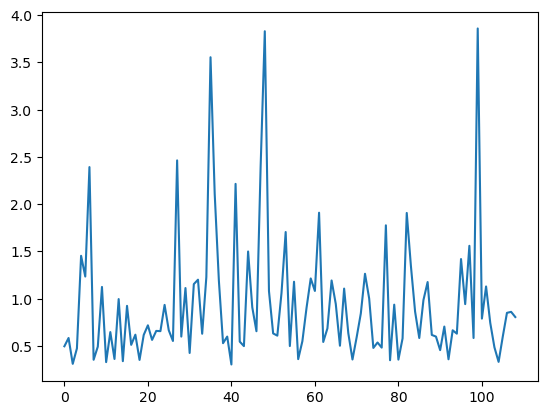

In [461]:
en_test = y_test[:, -3]
# Reshape the array into a 2D array with 12 columns
en_test_reshaped = en_test.reshape(-1, 12)

# Sum every 12 elements by summing along the first axis
en_test_sum = en_test_reshaped.sum(axis=1)

plt.plot(en_test_sum)

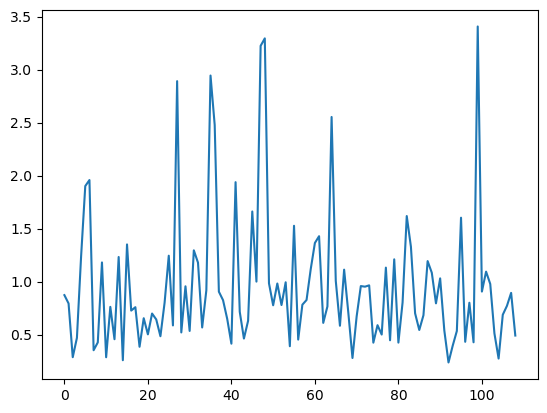

In [462]:
en_test_pred = y_test_pred[:, -3]
# Reshape the array into a 2D array with 12 columns
en_test_pred_reshaped = en_test_pred.reshape(-1, 12)

# Sum every 12 elements by summing along the first axis
en_test_pred_sum = en_test_pred_reshaped.sum(axis=1)

plt.plot(en_test_pred_sum)

In [463]:
mean_absolute_error(en_test_sum, en_test_pred_sum)

0.2244423492601485

In [467]:
mean_absolute_error(en_test_sum, en_test_pred_sum)/np.mean(en_test_sum)

0.23775518560175965

In [465]:
np.sqrt(mean_squared_error(en_test_sum,en_test_pred_sum))

0.32127620886370006

In [468]:
np.sqrt(mean_squared_error(en_test_sum,en_test_pred_sum))/np.mean(en_test_sum)

0.34033276215301794

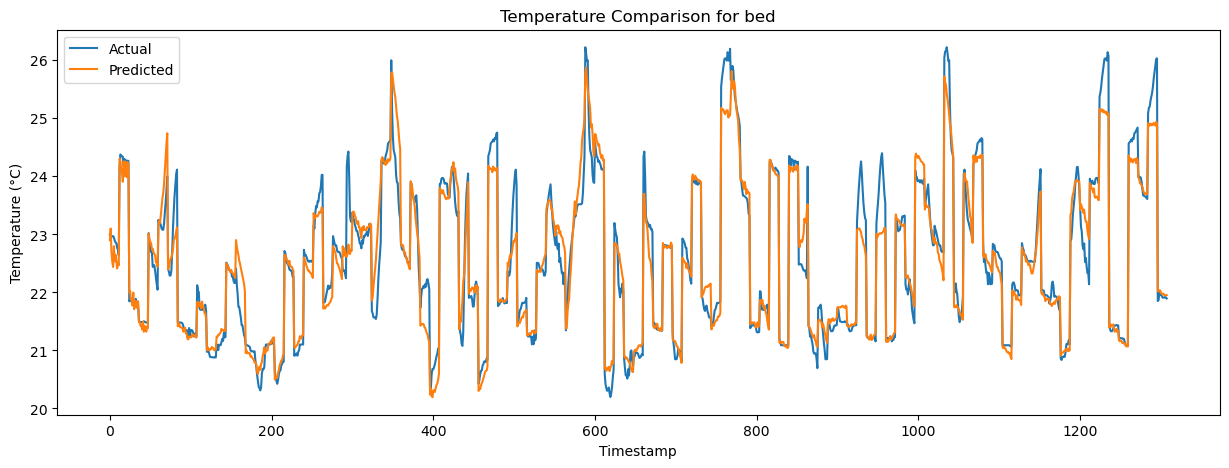

0.02020764681518561


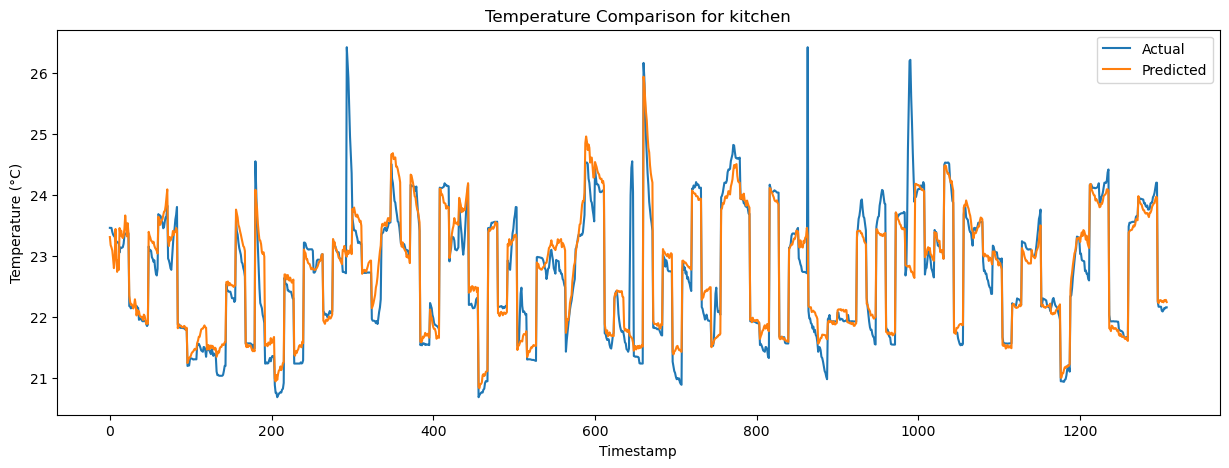

0.02331005680791774


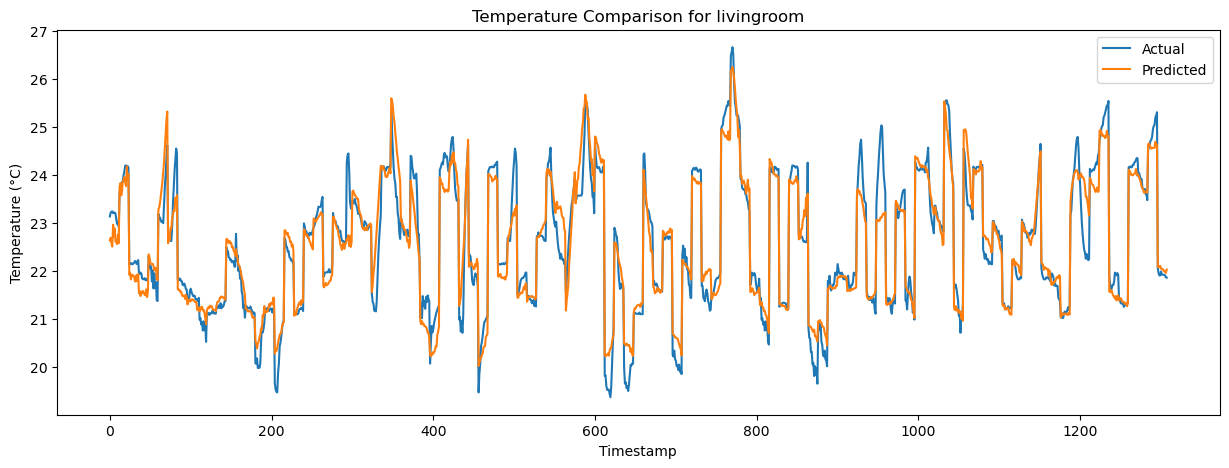

0.0233461900937083


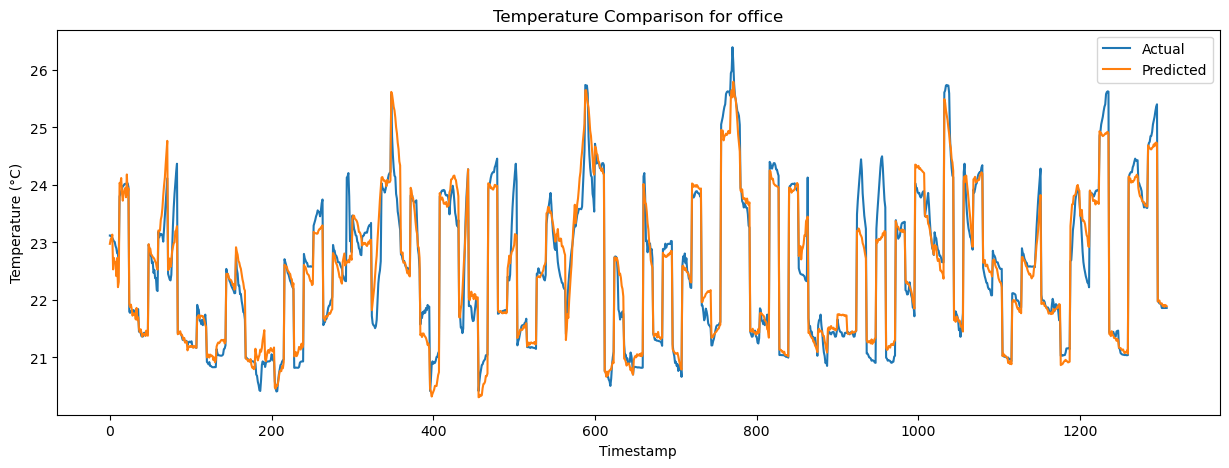

0.018902406362660988


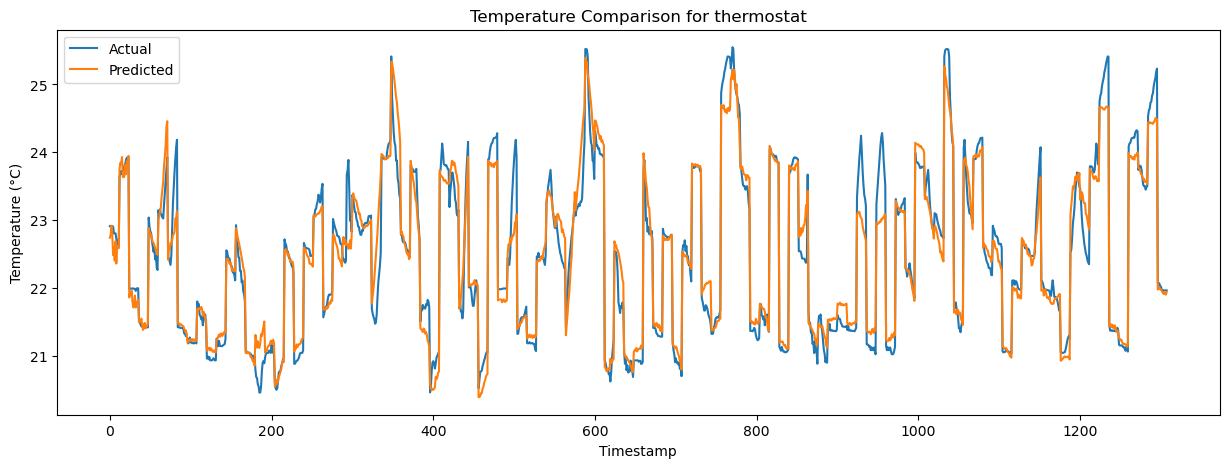

0.016989902773284476


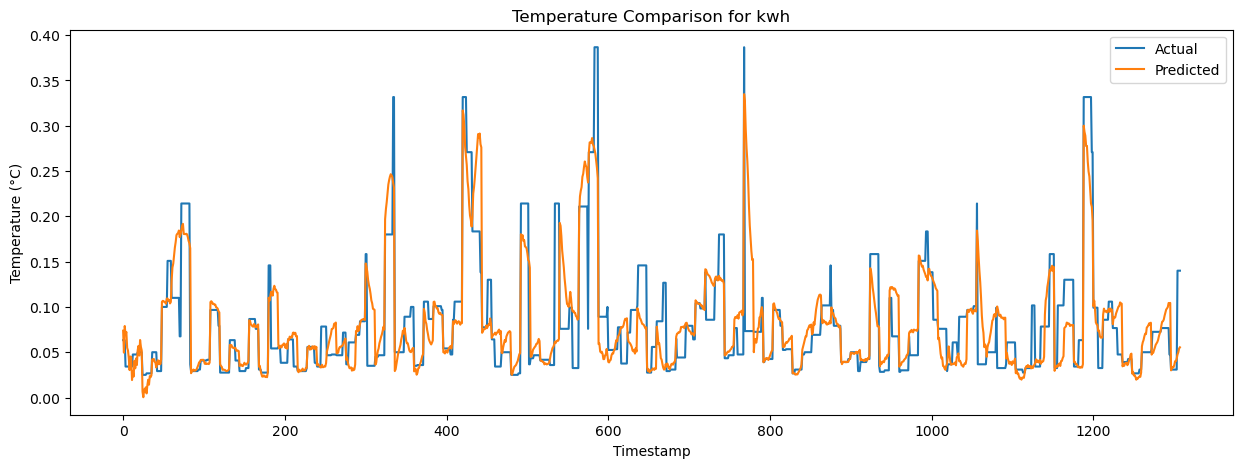

0.0021100321729921414


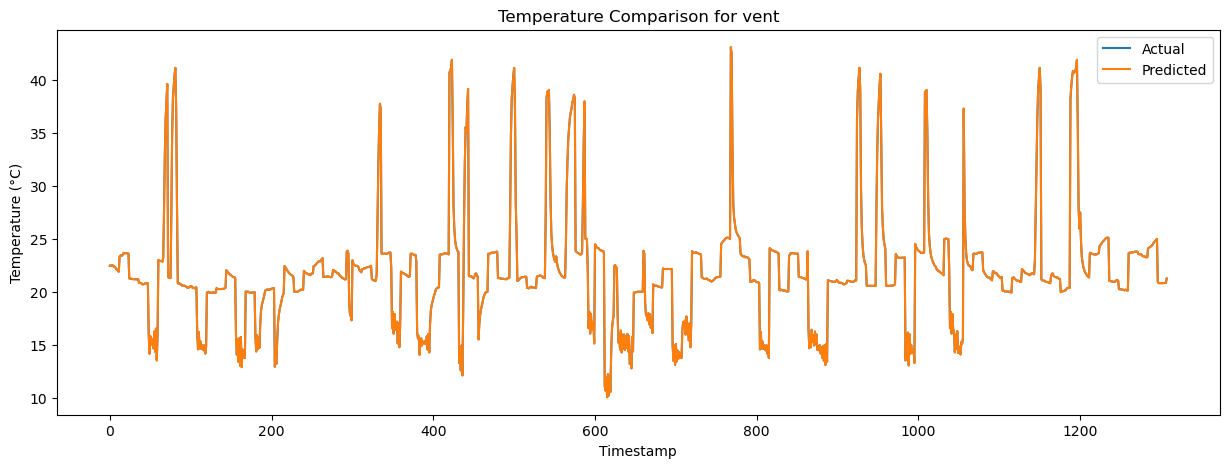

0.0


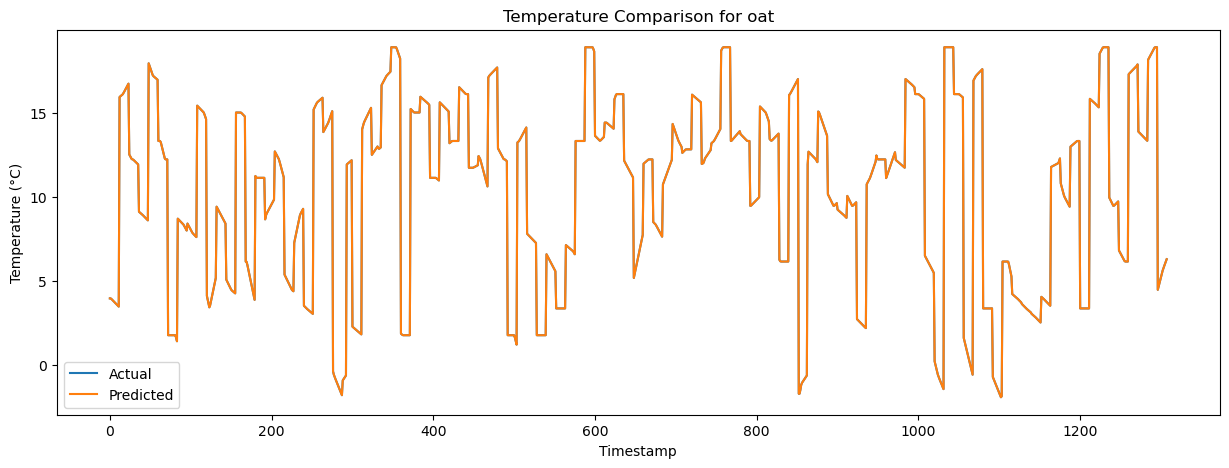

0.0


In [416]:
import matplotlib.pyplot as plt

# Get the timestamps for the test set
# test_timestamps = df_merged.iloc[train_length + input_length:train_length + input_length + test_length].index

# Create a plot for each location
for i, location in enumerate(df_merged.columns):
    plt.figure(figsize=(15, 5))
    plt.plot(y_test[:, i], label="Actual")
    plt.plot(y_test_pred[:, i], label="Predicted")
    plt.title(f"Temperature Comparison for {location}")
    plt.xlabel("Timestamp")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.savefig(f"Temperature Comparison for {location}.png", bbox_inches = 'tight')
    plt.show()
    print(np.sqrt(mean_squared_error(y_test[:, i], y_test_pred[:, i]))/np.mean(y_test[:, i]))

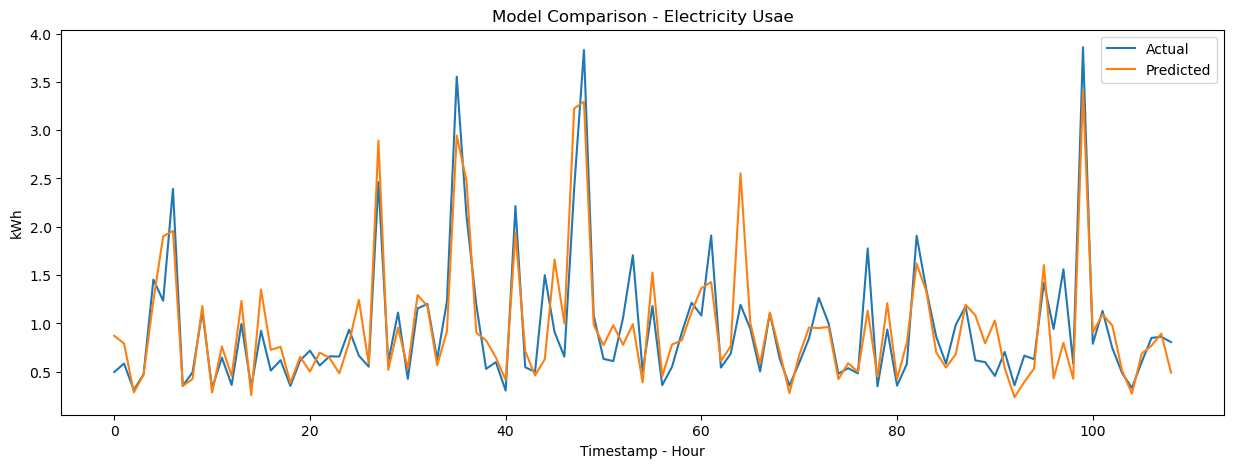

In [469]:
plt.figure(figsize=(15, 5))
plt.plot(en_test_sum, label="Actual")
plt.plot(en_test_pred_sum, label="Predicted")
plt.title("Model Comparison - Electricity Usae")
plt.xlabel("Timestamp - Hour")
plt.ylabel("kWh")
plt.legend()
plt.savefig("Electricity Comparison.png", bbox_inches = 'tight')
plt.show()

In [107]:
# from scipy.optimize import minimize



# # Parameters
# prediction_horizon = 12
# setpoint = 0.65  # Desired indoor air temperature
# control_effort_weight = 0.0001  # Weight for control effort in the objective function

# def predict_temperature_all(cv_input, x_hist, cv_hist, oat_hist, model):
#     cv_input = torch.tensor(cv_input, dtype=torch.float32)
#     x_hist = x_hist.reshape((1, x_hist.shape[0],cols_feature+cols_cv+cols_oat))
#     cv_input = cv_input.reshape((1,cv_input.shape[0],cols_cv))
#     oat_hist = oat_hist.reshape((1,oat_hist.shape[0],cols_oat))
#     X_hist_full = torch.dstack((x_hist, cv_input, oat_hist))
    
#     model.eval()
#     with torch.no_grad():
#         y_pred = model(X_hist_full)
        
#     return y_pred

# def predict_temperature(cv_input, x_hist, cv_hist, oat_hist, model):
#     cv_input = torch.tensor(cv_input, dtype=torch.float32)
#     x_hist = x_hist.reshape((1, x_hist.shape[0],cols_feature+cols_cv+cols_oat))
#     cv_input = cv_input.reshape((1,cv_input.shape[0],cols_cv))
#     oat_hist = oat_hist.reshape((1,oat_hist.shape[0],cols_oat))
#     X_hist_full = torch.dstack((x_hist, cv_input, oat_hist))
    
#     model.eval()
#     with torch.no_grad():
#         y_pred = model(X_hist_full)
#     y_pred_loc = y_pred[0,:,location]
#     return y_pred_loc

# def mpc_objective(x, x_hist, cv_hist, oat_hist, y_ref, prediction_horizon, location):
#     total_error = 0

#     y_pred = predict_temperature(x, x_hist, cv_hist, oat_hist, best_model)
#     y_pred = np.array(y_pred)
#     y_ref = np.array(y_ref)
#     squared_errors = np.square(y_pred - y_ref)
#     total_error += np.sum(squared_errors)
#     return total_error

# # Define constraints and bounds for the optimization problem
# control_bounds = [(0, 1)] * prediction_horizon  # Assuming thermostat temperature range is between 15 and 30 degrees Celsius
# location = 0
# ref_loc = ref_scaled[location]
# cv_opt = []
# y_pred_all = []
# for x_hist, cv_hist, oat_hist, y_true in zip(X_test, cv_test, oat_test, y_test):
#     y_ref = ref_loc*torch.ones_like(y_true[:,location])
#     result = minimize(
#         mpc_pso_objective,
#         x0=cv_hist,  # Initial guess for control input
#         args=(x_hist, cv_hist, oat_hist, y_ref, prediction_horizon, location),
#         bounds=control_bounds,
#         method='SLSQP',  # Sequential Least Squares Programming (SLSQP) method for constrained optimization
#     )
#     cv_opt.append(result.x)
#     cv_curr = np.array(result.x)
#     y_pred_curr = predict_temperature_all(cv_curr, x_hist, cv_hist, oat_hist, best_model)
#     y_pred_all.append(y_pred_curr)
#     print("Optimal vent temperatures:", result.x)
#     print("Minimum objective function value:", result.fun)

In [443]:
# Load the best model
best_model = LSTMModel(cols_feature+cols_cv*2+cols_oat*2, hidden_size, cols_feature * output_length)
best_model.load_state_dict(torch.load("best_model.pt"))

num_samples = int(60 / 5)

# Test the model
best_model.eval()
with torch.no_grad():
    y_test_pred = best_model(X_test_full)

y_test_pred = torch.tensor(y_test_pred, dtype=torch.float32)
X_val, X_test, y_val, y_test, cv_val, cv_test, oat_val, oat_test = train_test_split(X_temp, y_temp, cv_temp, oat_temp, test_size=0.5, random_state=42)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
cv_test = torch.tensor(cv_test, dtype=torch.float32)
oat_test = torch.tensor(oat_test, dtype=torch.float32)

/var/folders/0w/98g43rqs1psflll78k6ctzr00000gn/T/ipykernel_65742/352234031.py:12: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [444]:
from pyswarm import pso

best_model = LSTMModel(cols_feature+cols_cv*2+cols_oat*2, hidden_size, cols_feature * output_length)
best_model.load_state_dict(torch.load("best_model.pt"))

num_samples = int(60 / 5)

def predict_temperature_all(cv_input, x_hist, cv_hist, oat_hist, model):
    cv_input = torch.tensor(cv_input, dtype=torch.float32)
    x_hist = x_hist.reshape((1, x_hist.shape[0],cols_feature+cols_cv+cols_oat))
    cv_input = cv_input.reshape((1,cv_input.shape[0],cols_cv))
    oat_hist = oat_hist.reshape((1,oat_hist.shape[0],cols_oat))
    X_hist_full = torch.dstack((x_hist, cv_input, oat_hist))
    
    model.eval()
    with torch.no_grad():
        y_pred = model(X_hist_full)
        
    return y_pred
    
def mpc_objective(x, x_hist, cv_hist, oat_hist, y_ref, prediction_horizon, location):
    total_error = 0
    y_pred = predict_temperature_all(x, x_hist, cv_hist, oat_hist, best_model)
    y_pred_loc = y_pred[0,:,location]
    y_pred_loc = np.array(y_pred_loc)
    y_energy = y_pred[0,:,-3]
    y_energy = np.array(y_energy)
    y_ref = np.array(y_ref)
    squared_errors = np.square(y_pred_loc - y_ref)
    total_error += 100*np.sum(squared_errors)
    squared_pen = np.square(x - 0.4*np.ones_like(x))
    total_error += 0.00001*np.sum(squared_pen)
    squared_en = 100*np.square(y_energy)
    total_error += np.sum(squared_en)
    total_error += 0.00001*np.std(x)
    return total_error

# MPC using PSO
prediction_horizon = 12  # 1 hour, 5 minutes interval

# Define constraints for PSO
lb = [0] * prediction_horizon  # Lower bound for vent temperature
ub = [0.9] * prediction_horizon  # Upper bound for vent temperature

location = 0
ref_loc = ref_scaled[location]
cv_opt = []
y_pred_all = []
for x_hist, cv_hist, oat_hist, y_true in zip(X_test, cv_test, oat_test, y_test):
    y_ref = ref_loc*torch.ones_like(y_true[:,location])
    # Optimize using PSO
    xopt, fopt = pso(mpc_objective, lb, ub, args=(x_hist, cv_hist, oat_hist, y_ref, prediction_horizon, location),
                     swarmsize=100, omega=0.8, phip=0.5, phig=0.5, maxiter=100, minstep=1e-8, minfunc=1e-8, debug=False)
    cv_opt.append(xopt)
    cv_curr = np.array(xopt)
    y_pred_curr = predict_temperature_all(cv_curr, x_hist, cv_hist, oat_hist, best_model)
    y_pred_all.append(y_pred_curr)
    print("Optimal vent temperatures:", xopt)
    print("Minimum objective function value:", fopt)


Stopping search: Swarm best objective change less than 1e-08
Optimal vent temperatures: [0.29992904 0.72233443 0.20520375 0.9        0.86692809 0.80822639
 0.55075069 0.82807253 0.9        0.62826668 0.         0.1341295 ]
Minimum objective function value: 228.39127281006955
Stopping search: Swarm best objective change less than 1e-08
Optimal vent temperatures: [0.38433444 0.40473712 0.4337893  0.40431576 0.3970568  0.37698953
 0.41634164 0.39995781 0.40086899 0.39913257 0.33887126 0.        ]
Minimum objective function value: 295.2683300719373
Stopping search: maximum iterations reached --> 100
Optimal vent temperatures: [0.51993621 0.72550081 0.76559319 0.74424176 0.72064856 0.29236427
 0.68670784 0.00485913 0.78900477 0.65401829 0.65870743 0.29128497]
Minimum objective function value: 195.6919535817235
Stopping search: maximum iterations reached --> 100
Optimal vent temperatures: [0.12691454 0.57375809 0.79238093 0.08193937 0.84162959 0.87048456
 0.35697828 0.72770881 0.04335909 0.7

In [445]:
y_pred_all = torch.stack(y_pred_all)

In [446]:
y_pred_all = y_pred_all.squeeze(dim=1)

In [447]:
cv_opt = torch.tensor(cv_opt, dtype=torch.float32)

In [448]:
y_sim = torch.dstack((y_pred_all, cv_opt, oat_test))
y_test = torch.dstack((y_test, cv_test, oat_test))
# Inverse transform the predictions and ground truth values
y_sim = scaler.inverse_transform(y_sim.reshape(-1, df_merged.shape[1]))
y_test = scaler.inverse_transform(y_test.reshape(-1, df_merged.shape[1]))

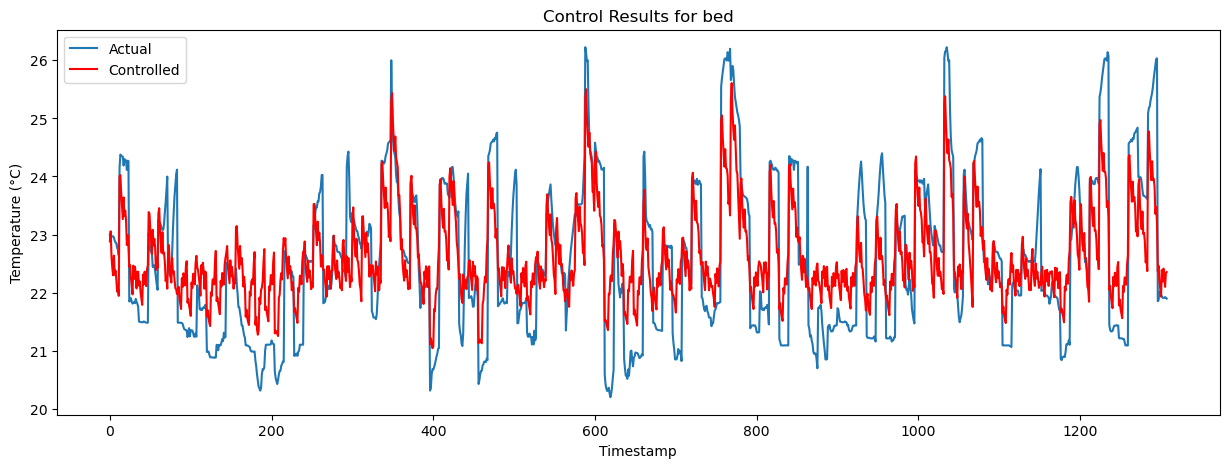

bed: RMSE (controlled) = 0.8433125636322448, RMSE (actual) = 1.3395867857426362


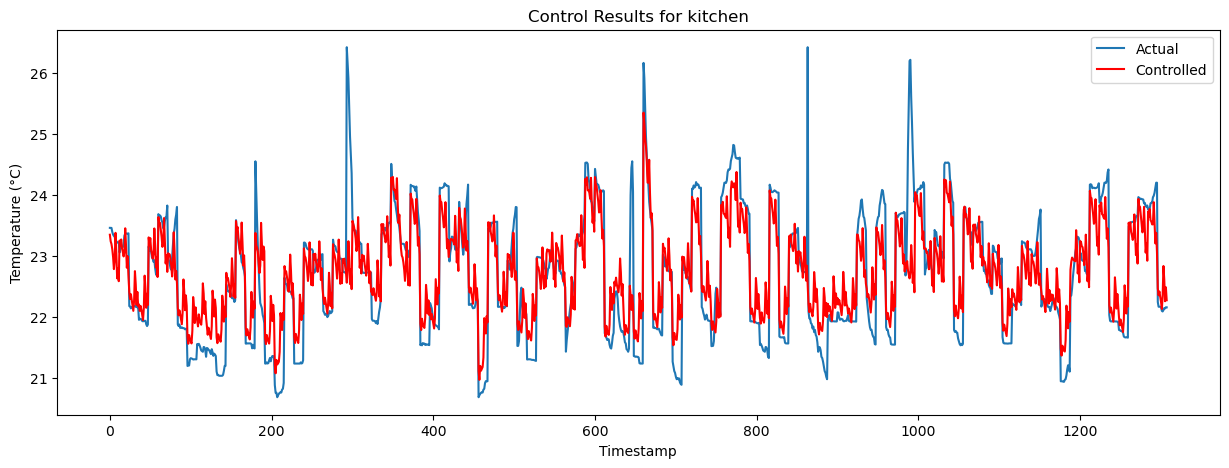

kitchen: RMSE (controlled) = 0.7393788143055114, RMSE (actual) = 1.0559096589214187


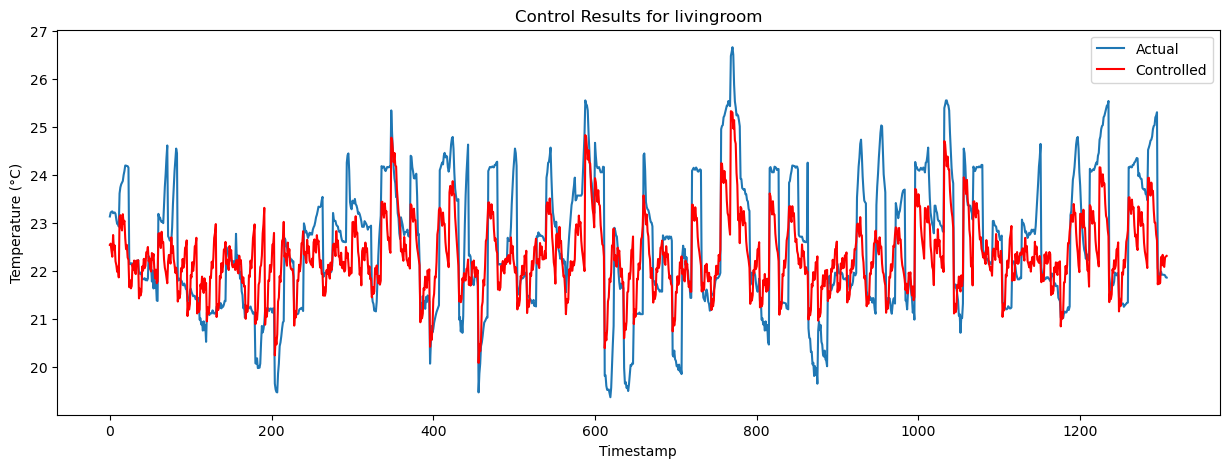

livingroom: RMSE (controlled) = 1.0186596365590452, RMSE (actual) = 1.377395222330196


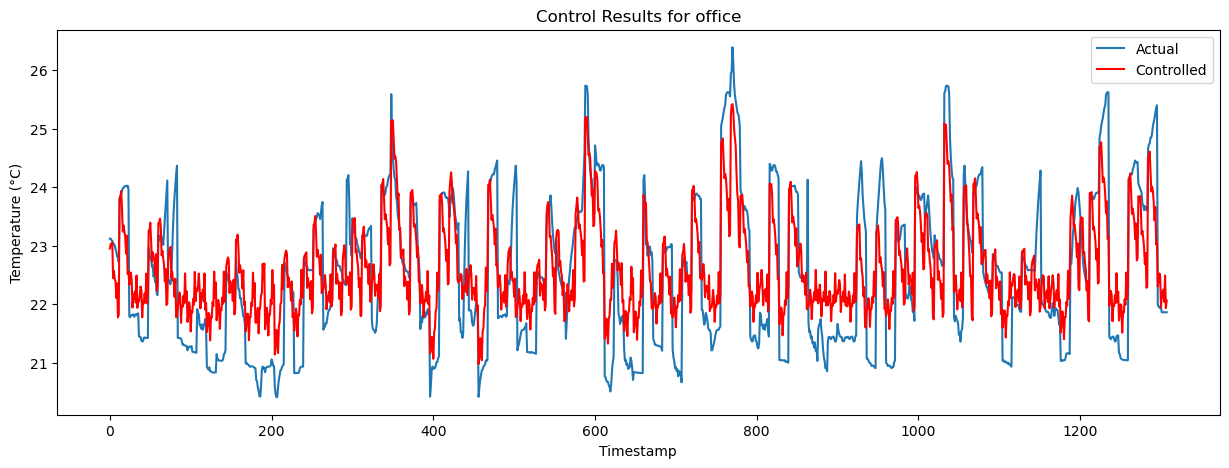

office: RMSE (controlled) = 0.867977888246413, RMSE (actual) = 1.281401135405532


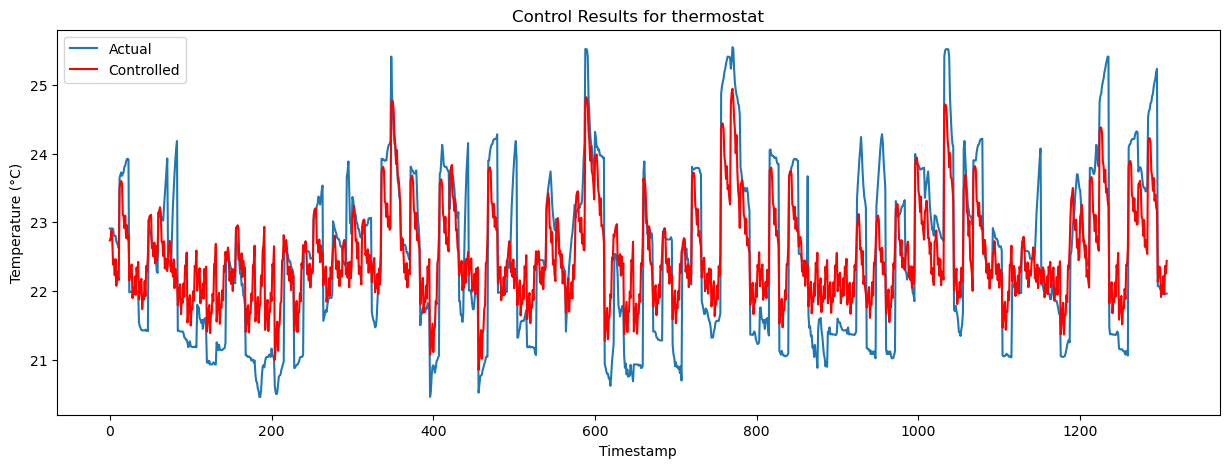

thermostat: RMSE (controlled) = 0.8410700374841543, RMSE (actual) = 1.203029614992826


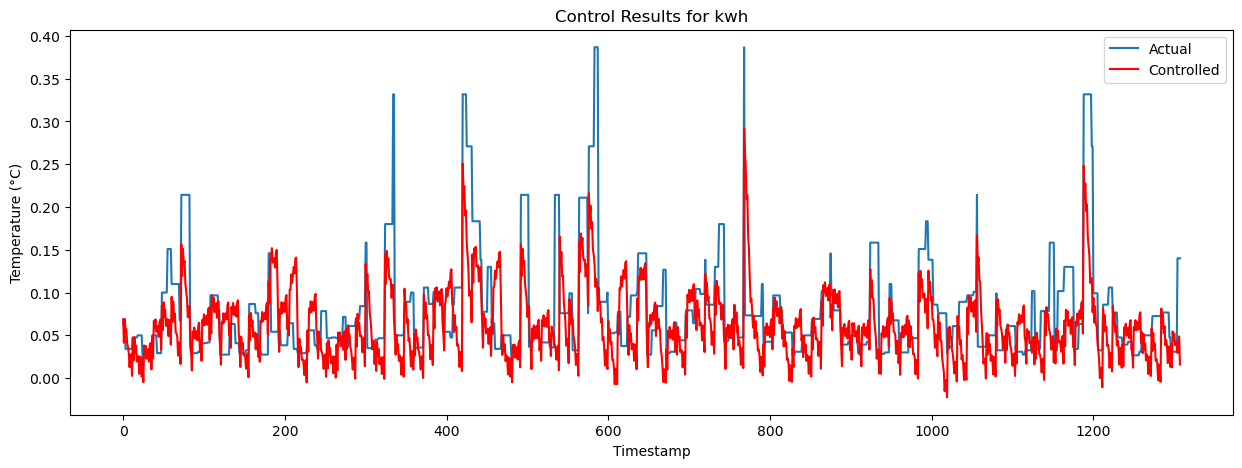

kwh: RMSE (controlled) = 22.939093571801685, RMSE (actual) = 22.4214148621267


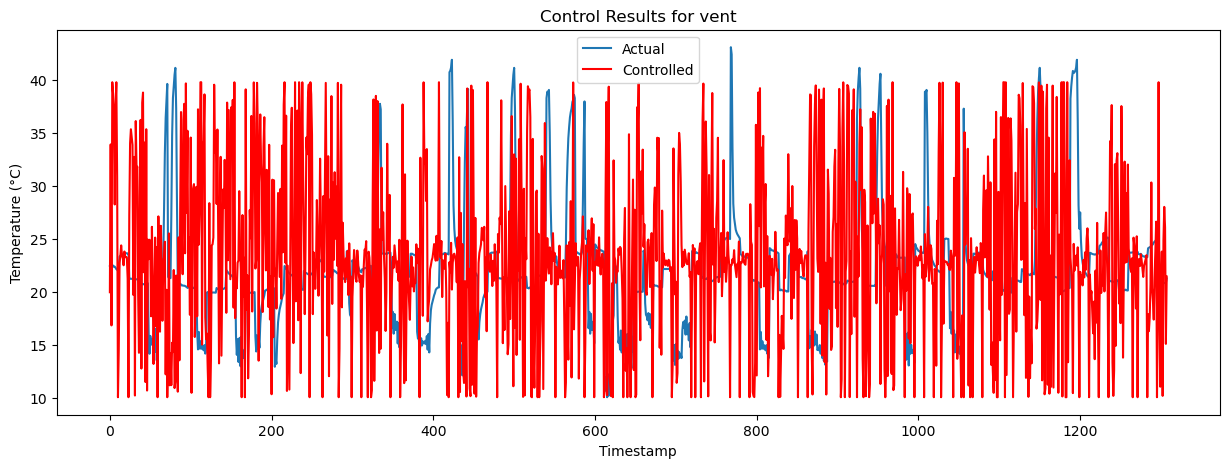

vent: RMSE (controlled) = 7.958182349263759, RMSE (actual) = 5.237831529010848


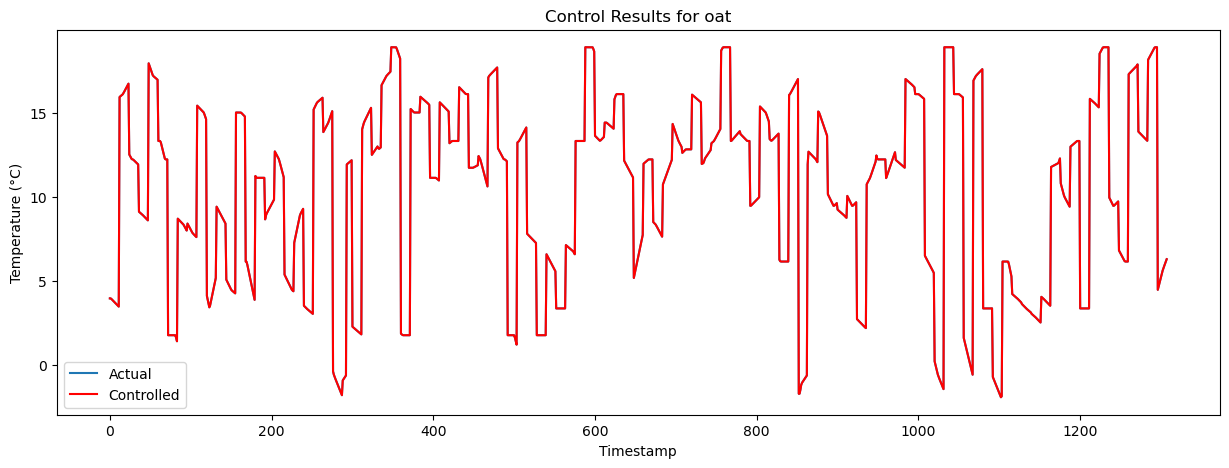

oat: RMSE (controlled) = 13.679064677387936, RMSE (actual) = 13.222002977638729


In [474]:
import matplotlib.pyplot as plt

# Get the timestamps for the test set
# test_timestamps = df_merged.iloc[train_length + input_length:train_length + input_length + test_length].index

# Create a plot for each location
for i, location in enumerate(df_merged.columns):
    plt.figure(figsize=(15, 5))
    plt.plot(y_test[:, i],  label="Actual")
    plt.plot(y_sim[:, i], 'r-', label="Controlled")
    plt.title(f"Control Results for {location}")
    plt.xlabel("Timestamp")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.savefig(f"Control Results for {location}.png", bbox_inches = 'tight')
    plt.show()
    rmse_sim = np.sqrt(mean_squared_error(y_sim[:, i], 23*np.ones_like(y_sim[:, i])))
    rmse_test = np.sqrt(mean_squared_error(y_test[:, i], 22.5*np.ones_like(y_test[:, i])))
    print(f"{location}: RMSE (controlled) = {rmse_sim}, RMSE (actual) = {rmse_test}")

In [450]:
np.abs(y_sim[:,-3]).sum()

79.95000164508198

In [451]:
y_test[:,-3].sum()

102.89666661712187

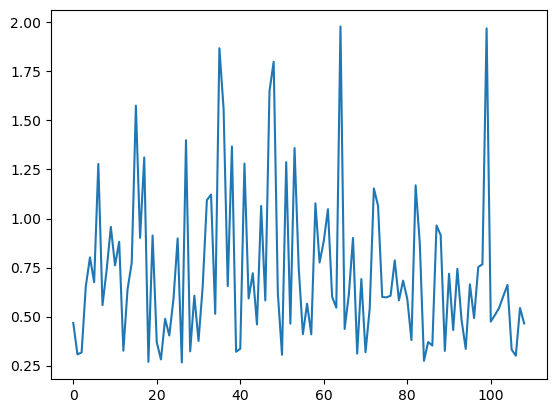

In [471]:
en_sim = y_sim[:, -3]
# Reshape the array into a 2D array with 12 columns
en_sim_reshaped = en_sim.reshape(-1, 12)

# Sum every 12 elements by summing along the first axis
en_sim_sum = en_sim_reshaped.sum(axis=1)

plt.plot(en_sim_sum)

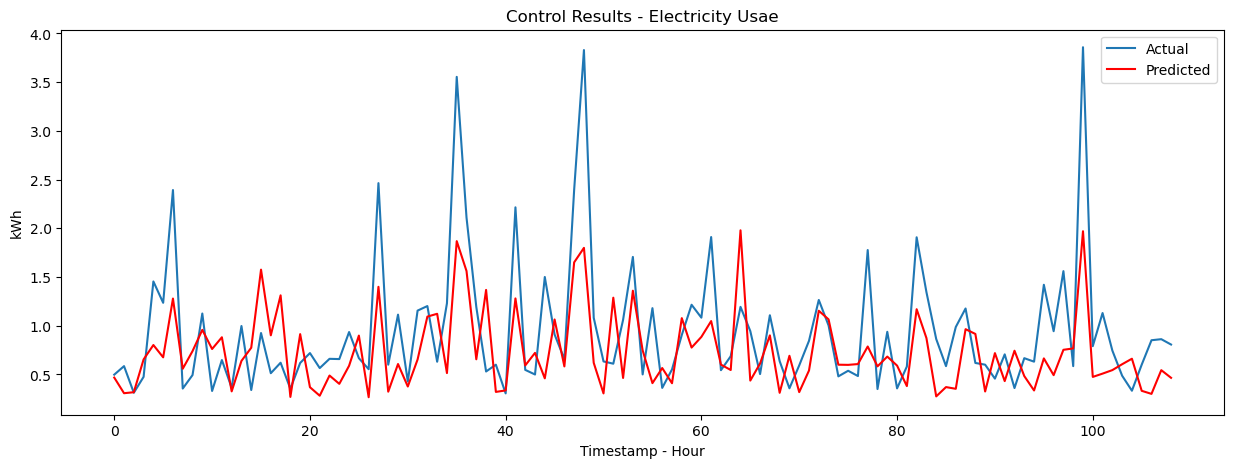

In [473]:
plt.figure(figsize=(15, 5))
plt.plot(en_test_sum, label="Actual")
plt.plot(en_sim_sum, 'r',label="Predicted")
plt.title("Control Results - Electricity Usae")
plt.xlabel("Timestamp - Hour")
plt.ylabel("kWh")
plt.legend()
plt.savefig("Electricity Comparison Control.png", bbox_inches = 'tight')
plt.show()

In [476]:
1 - np.abs(y_sim[:,-3]).sum() / y_test[:,-3].sum()

0.2230068837645085